### Import necessory modules

In [26]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
from torchvision.datasets import ImageFolder


### Some necessary settings

In [27]:
train_dir = "C:/Users/USER/Downloads/damage-classification-walls/dataset_wall/wall_damage"
save_path = "C:/Users/USER/Downloads/damage-classification-walls/dataset_wall/model.pth"
batch_size = 32
epochs = 30
num_classes = 3
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# 1. Transforms

class TargetedAugmentDataset(ImageFolder):
    def __init__(self, root, base_transform, b_transform, b_class_idx=1):
        super().__init__(root, transform=None)
        self.base_transform = base_transform
        self.b_transform = b_transform
        self.b_class_idx = b_class_idx

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = self.loader(path)

        if label == self.b_class_idx:
            img = self.b_transform(img)
        else:
            img = self.base_transform(img)

        return img, label


train_transform =  transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

b_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.4),
    transforms.ToTensor(),  # ← 先轉 tensor
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),  # ← 然後才 Erasing
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std  = [0.229, 0.224, 0.225])
])

train_dataset = TargetedAugmentDataset(
    root=train_dir,
    base_transform=train_transform,
    b_transform=b_transform,
    b_class_idx=1  # class 1 是 B 類
)

### Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.8208281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.18248373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5081771..

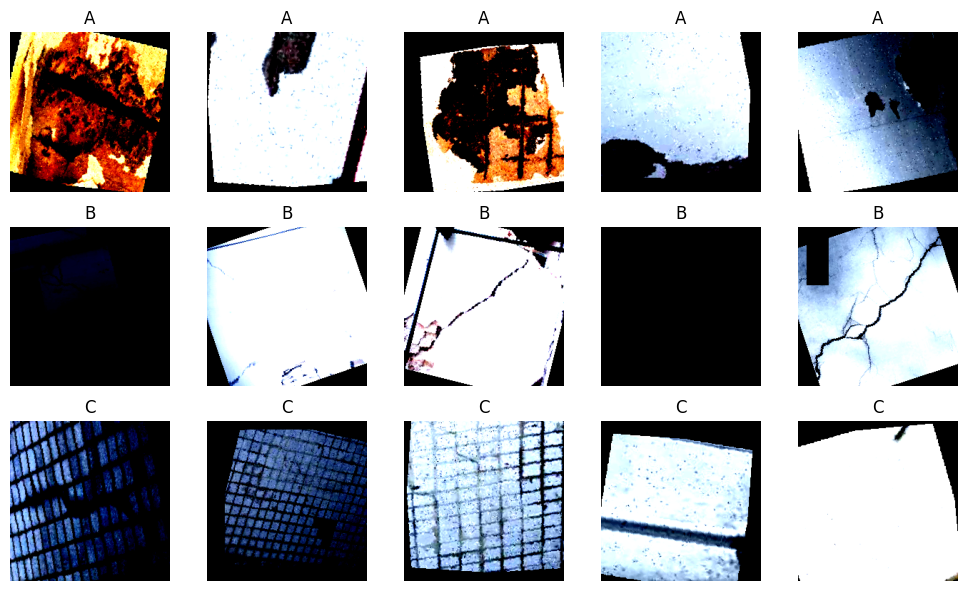

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..1.9776908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6116778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6813945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905448].


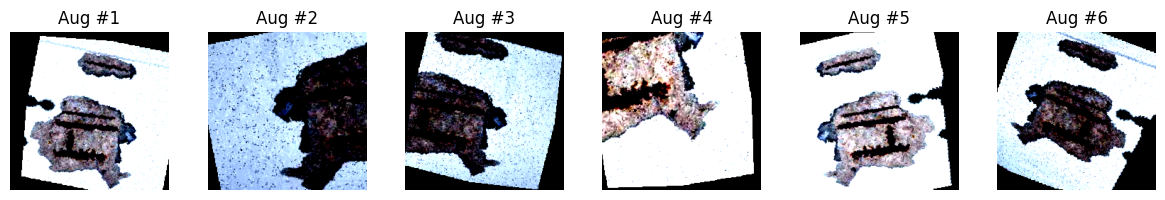

In [29]:
import matplotlib.pyplot as plt
import torchvision

def show_data_images(dataset, class_names, samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))
    shown = {cls: 0 for cls in range(len(class_names))}
    idx = 0

    for img, label in dataset:
        if shown[label] < samples_per_class:
            plt.subplot(len(class_names), samples_per_class, idx + 1)
            plt.imshow(img.permute(1, 2, 0))  # C, H, W → H, W, C
            plt.title(class_names[label])
            plt.axis('off')
            shown[label] += 1
            idx += 1
        if idx >= samples_per_class * len(class_names):
            break

    plt.tight_layout()
    plt.show()

from PIL import Image
import matplotlib.pyplot as plt

def show_data_augmentation(dataset, transform, index=0, times=6):
    """顯示同一張圖片經過多次 augmentation 的結果"""
    # 如果是 Subset，從原始 ImageFolder 抓檔案路徑
    if isinstance(dataset, torch.utils.data.Subset):
        image_path, label = dataset.dataset.imgs[dataset.indices[index]]
    else:
        image_path, label = dataset.imgs[index]

    img = Image.open(image_path).convert("RGB")

    fig, axs = plt.subplots(1, times, figsize=(times * 2, 2))
    for i in range(times):
        aug_img = transform(img)
        axs[i].imshow(aug_img.permute(1, 2, 0))  # Tensor to HWC
        axs[i].axis('off')
        axs[i].set_title(f'Aug #{i+1}')
    plt.tight_layout()
    plt.show()

class_names = train_dataset.dataset.classes if isinstance(train_dataset, torch.utils.data.Subset) else train_dataset.classes
show_data_images(train_dataset, class_names)

show_data_augmentation(train_dataset, train_transform, index=10, times=6)


In [30]:
# 2. Dataset & Split
train_dir = "C:/Users/USER/Downloads/damage-classification-walls/dataset_wall/wall_damage"
test_dir = "C:/Users/USER/Downloads/damage-classification-walls/dataset_wall/test"
full_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
idx_to_class = {0: 'A', 1: 'B', 2: 'C'}

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

from torch.utils.data import WeightedRandomSampler

class_counts = [62, 57, 145]

targets = [train_dataset.dataset.imgs[i][1] for i in train_dataset.indices]

class_weights = [1.0 / class_counts[t] for t in targets]

sampler = WeightedRandomSampler(class_weights, num_samples=len(targets), replacement=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


class ResNet50_SA(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        base = resnet50(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(base.children())[:-2])  # 去掉 avgpool & fc
        self.sa = SpatialAttention()  # 插入 Spatial Attention
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)          # (B, 2048, H, W)
        sa_map = self.sa(x)           # (B, 1, H, W)
        x = x * sa_map                # 應用注意力
        x = self.pool(x)              # (B, 2048, 1, 1)
        x = x.view(x.size(0), -1)     # 展平
        x = self.fc(x)
        return x
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 通道間 max-pooling 和 avg-pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = sorted(os.listdir(root), key=lambda x: int(x.split('.')[0]))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        path = os.path.join(self.root, self.image_files[idx])
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.image_files[idx]
    
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return ((1 - pt) ** self.gamma * -logpt).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return ((1 - pt) ** self.gamma * -logpt).mean()
    
def predict_tta(model, img_tensor, tta=5):
    model.eval()
    preds = []
    with torch.no_grad():
        for _ in range(tta):
            # 對 tensor 做簡單 TTA（可擴充更多）
            aug_img = img_tensor.clone()

            # ➕ 例如做水平翻轉
            if torch.rand(1).item() > 0.5:
                aug_img = torch.flip(aug_img, dims=[2])  # 水平翻轉 (W 維度)

            output = model(aug_img.unsqueeze(0).to(device))
            preds.append(output)
    return torch.mean(torch.stack(preds), dim=0)

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
# 3. Model setup

# 1. 定義模型
model = ResNet50_SA(num_classes=3).to(device)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

from collections import Counter

# 假設你有用 random_split，train_dataset 是 Subset，內部有 dataset 指到原始 ImageFolder
label_counts = Counter(train_dataset.dataset.targets)
class_counts = [label_counts[i] for i in range(num_classes)]

weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = torch.tensor([1.0/62, 1.0/57, 1.0/145])  # A, B, C 數量反比
criterion = FocalLoss(weight=class_weights.to(device), gamma=2.5)

Epoch 01 | Train Loss: 0.2601, Val Loss: 0.2327, Val Acc: 0.6038
Saved model
Epoch 02 | Train Loss: 0.1085, Val Loss: 0.3576, Val Acc: 0.5849
Epoch 03 | Train Loss: 0.0446, Val Loss: 0.3492, Val Acc: 0.6226
Saved model
Epoch 04 | Train Loss: 0.0261, Val Loss: 0.0681, Val Acc: 0.7170
Saved model
Epoch 05 | Train Loss: 0.0354, Val Loss: 0.0352, Val Acc: 0.7736
Saved model
Epoch 06 | Train Loss: 0.0186, Val Loss: 0.0445, Val Acc: 0.6981
Epoch 07 | Train Loss: 0.0128, Val Loss: 0.1846, Val Acc: 0.6981
Epoch 08 | Train Loss: 0.0074, Val Loss: 0.1542, Val Acc: 0.6981
Epoch 09 | Train Loss: 0.0215, Val Loss: 0.0728, Val Acc: 0.7736
Epoch 10 | Train Loss: 0.0037, Val Loss: 0.0678, Val Acc: 0.7358
Epoch 11 | Train Loss: 0.0085, Val Loss: 0.0831, Val Acc: 0.7736
Epoch 12 | Train Loss: 0.0038, Val Loss: 0.1737, Val Acc: 0.7170
Epoch 13 | Train Loss: 0.0295, Val Loss: 0.1632, Val Acc: 0.7925
Saved model
Epoch 14 | Train Loss: 0.0097, Val Loss: 0.0441, Val Acc: 0.8302
Saved model
Epoch 15 | Train L

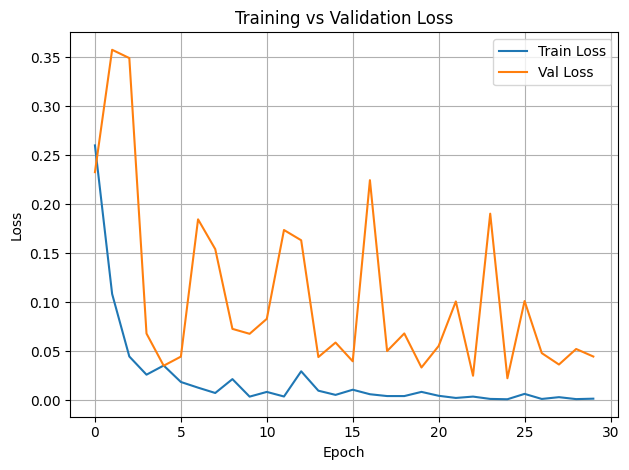

In [32]:
train_losses = []
val_losses = []
wrong_b_images = []  
best_val_acc = 0.0
best_val_loss = float('inf')
patience_limit = 5
patience_counter = 0


for epoch in range(30):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = correct / len(train_loader.dataset)

    # === Validation ===
    model.eval()
    val_total_loss = 0
    val_correct = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            val_total_loss += criterion(outputs, labels).item()
            val_correct += (preds == labels).sum().item()

            for img, label, pred in zip(imgs, labels, preds):
                if label == 1 and pred != 1:
                    wrong_b_images.append((img.cpu(), label.item(), pred.item()))

    val_loss = val_total_loss / len(val_loader)
    val_losses.append(val_loss)
    val_acc = val_correct / len(val_loader.dataset)
    
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("Saved model")


# === Loss Plot ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
results = []

model.eval()
with torch.no_grad():
    for imgs, fnames in tqdm(test_loader, desc="Predicting"):
        for img, fname in zip(imgs, fnames):
            output = predict_tta(model, img, tta=5)
            pred = torch.argmax(output).item()

            ID = int(fname.split('.')[0])
            label = idx_to_class[pred]
            results.append((ID, label))

output_csv = "C:/Users/USER/Downloads/damage-classification-walls/dataset_wall/submission.csv"

submission = pd.DataFrame(results, columns=["ID", "class"])
submission = submission.sort_values("ID")
submission.to_csv(output_csv, index=False)

print(f"Submission saved to: {output_csv}")


Predicting: 100%|██████████| 3/3 [00:20<00:00,  6.93s/it]

Submission saved to: C:/Users/USER/Downloads/damage-classification-walls/dataset_wall/submission.csv


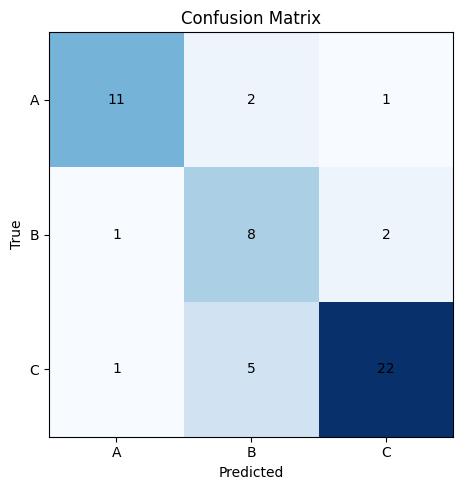

Confusion matrix saved at: c:\Users\USER\Downloads\confusion_matrix.png
              precision    recall  f1-score   support

           A       0.85      0.79      0.81        14
           B       0.53      0.73      0.62        11
           C       0.88      0.79      0.83        28

    accuracy                           0.77        53
   macro avg       0.75      0.77      0.75        53
weighted avg       0.80      0.77      0.78        53



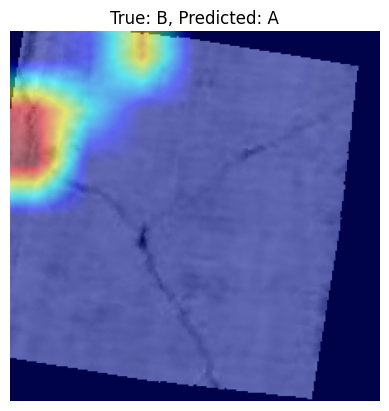

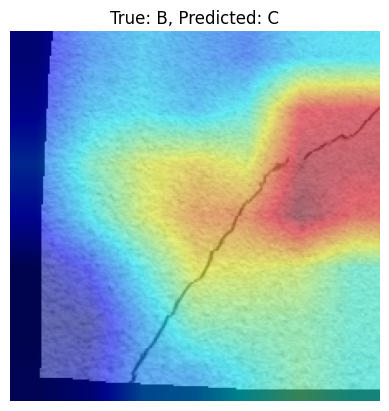

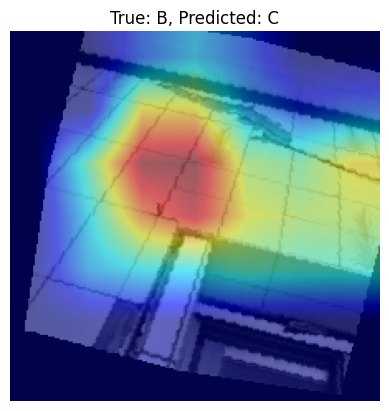

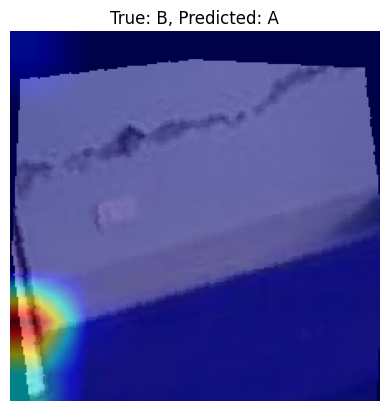

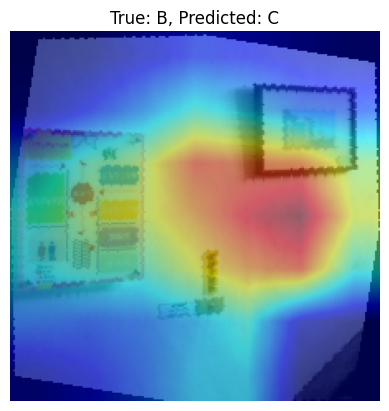

In [34]:
import cv2

idx_to_class = {0: 'A', 1: 'B', 2: 'C'}

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.numpy())

cm = confusion_matrix(all_labels, all_preds)
labels = ['A', 'B', 'C']

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm, cmap=plt.cm.Blues)

for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300) 
plt.show()

print("Confusion matrix saved at:", os.path.abspath("confusion_matrix.png"))

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=['A', 'B', 'C']))

target_layer = model.backbone[-1]  # ResNet 最後一層 conv
cam = GradCAM(model=model, target_layers=[target_layer])

for i, (img_tensor, label, pred) in enumerate(wrong_b_images[:5]):  # 只看前5張
    input_tensor = img_tensor.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])
    grayscale_cam = grayscale_cam[0, :]

    # 為了顯示用，先把 tensor 轉成 numpy 格式的圖片
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize 0~1

    cam_img = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # 顯示
    plt.imshow(cam_img)
    plt.title(f"True: B, Predicted: {['A','B','C'][pred]}")
    plt.axis('off')
    plt.show()
    
    cv2.imwrite(f"cam_wrong_B_{i}.png", cam_img[:, :, ::-1])  # RGB → BGR for OpenCV